# Asphalt Pavements Performance Prediction Using Tree Ensemble Models

## TLDR
Predict the performance of flexible pavements, specifically the International Roughness Index (IRI), using various Tree Ensemble models.

## Overview:
This notebook contains the code used to train and compare five Tree Ensemble models, namely Random Forest, Gradient Boosting Decision Tree, XGBoost, LightGBM, and CatBoost, for predicting asphalt pavement performance (using IRI as a target). The models are trained using the Long-Term Pavement Performance (LTPP) program data.

## Data Availability:
The dataset used in this study is available at [https://infopave.fhwa.dot.gov/DownloadTracker/Bucket/114229](https://infopave.fhwa.dot.gov/DownloadTracker/Bucket/114229).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Setup visualization parameters
plt.rcParams['figure.dpi'] = 400
sns.set_context('notebook')
sns.set_style("ticks")

In [2]:
# Load and adjust data
df = pd.read_csv('data/processed/data.csv')
df.rename({
    'ACCUMULATED_AADTT': 'AADTT',
}, inplace=True, axis=1)

In [3]:
df.head()

YEAR   SN  PRECIPITATION  TEMPERATURE     IRI  INITIAL_IRI STATION_ID  AGE  \
0  1989  6.1    1372.800049         12.0  0.8984       0.8984    34_1638  4.0   
1  1990  6.1    1137.000000         13.8  0.9420       0.8984    34_1638  5.0   
2  1991  6.1    1059.800049         13.9  0.9394       0.8984    34_1638  6.0   
3  1992  6.1     921.700012         12.2  0.8992       0.8984    34_1638  7.0   
4  1993  6.1    1193.599976         12.9  0.9228       0.8984    34_1638  8.0   

    AADTT  
0  1190.0  
1  2440.0  
2  3870.0  
3  5485.0  
4  6631.0

In [4]:
df.describe().T

count         mean          std          min          25%  \
YEAR           612.0  1996.338235     5.160118  1989.000000  1992.000000   
SN             612.0     4.563725     1.539090     2.000000     3.600000   
PRECIPITATION  612.0  1058.423273   458.247140    92.199997   700.850006   
TEMPERATURE    612.0    15.374463     6.062208     2.700000    10.016667   
IRI            612.0     1.388706     0.612876     0.620800     0.906400   
INITIAL_IRI    612.0     1.226592     0.467070     0.640600     0.888200   
AGE            612.0    16.070261     7.434381     1.000000    10.000000   
AADTT          612.0  2998.134259  4019.191719    11.000000   668.500000   

                       50%          75%         max  
YEAR           1995.500000  1999.000000   2016.0000  
SN                4.200000     5.500000      8.3000  
PRECIPITATION  1140.716675  1444.950012   2091.0000  
TEMPERATURE      16.200001    19.466667     25.9000  
IRI               1.188500     1.742700      4.0048  
INITIAL_IRI       1.057300     1.525600      2.5150  
AGE              15.500000    21.000000     38.0000  
AADTT          1553.500000  3665.875000  27470.0000

In [5]:
data_clean = df.drop(['STATION_ID'], axis=1)

In [6]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 30000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='ticks', font_scale=1.6)

g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
g.savefig('img/scatter_matrix.png')

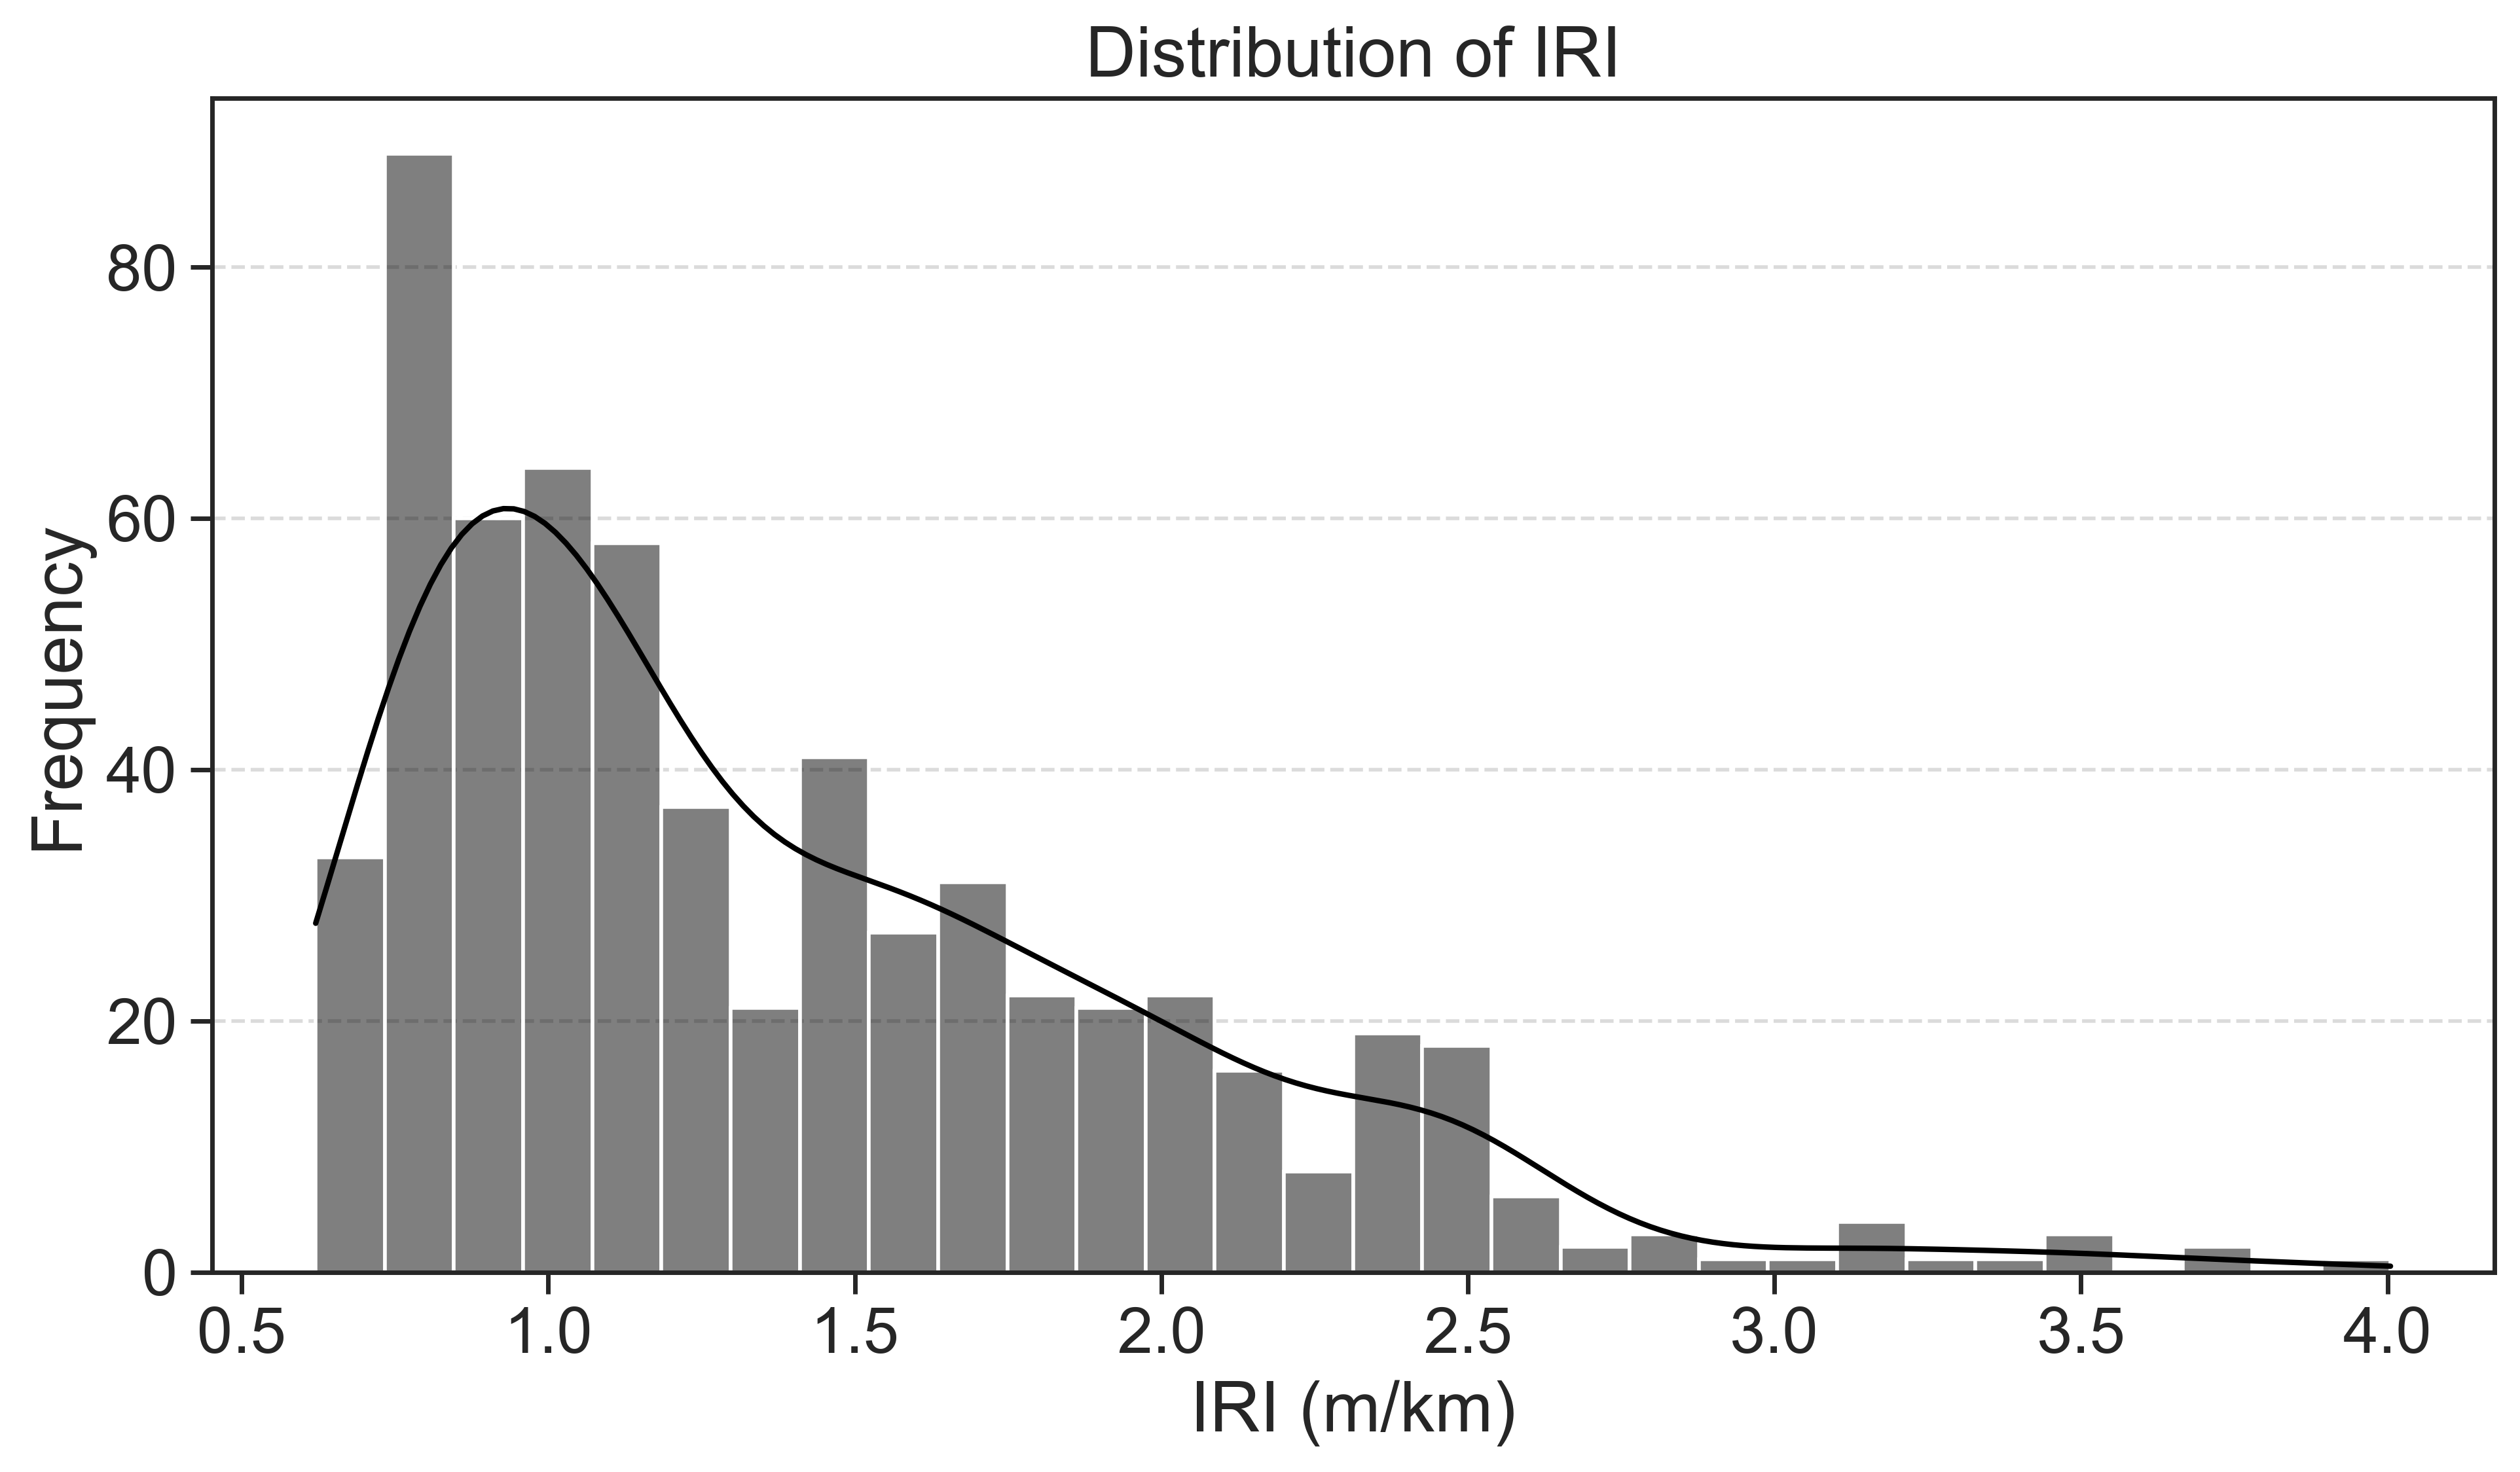

In [7]:
# Plotting IRI Hist
plt.figure(figsize=(10, 6))
sns.histplot(df['IRI'], kde=True, bins=30, color='black')
plt.title('Distribution of IRI')
plt.xlabel('IRI (m/km)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/IRI_Hist.png')
plt.show()


In [8]:
# Data splitting
y = df['IRI']
columns_to_drop = ['IRI', 'YEAR', 'STATION_ID']
X = df.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=0)

In [9]:
# Define and train regressors
regressors = {
    'Random Forest': RandomForestRegressor(random_state=42, max_depth=4),
    'GBDT': GradientBoostingRegressor(random_state=42, max_depth=4),
    'XGBoost': xgb.XGBRegressor(random_state=42, max_depth=4),
    'CatBoost': CatBoostRegressor(random_state=42, depth=4, verbose=0),
    'LightGBM': LGBMRegressor(random_state=42, max_depth=4)
}

results = {}
importances = {}

for name, reg in regressors.items():
    reg.fit(X_train, y_train)
    results[name] = reg.predict(X_test)
    if name == "CatBoost":
        normalized_importance = reg.get_feature_importance() / sum(reg.get_feature_importance())
        importances[name] = (normalized_importance * 100).astype(int)
    elif name == "LightGBM":
        normalized_importance = reg.feature_importances_ / sum(reg.feature_importances_)
        importances[name] = (normalized_importance * 100).astype(int)
    else:
        importances[name] = (reg.feature_importances_ * 100).astype(int)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 6
[LightGBM] [Info] Start training from score 1.394508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [10]:
# Display feature importances
df_importances = pd.DataFrame(importances, index=X_test.columns)
df_importances.T

SN  PRECIPITATION  TEMPERATURE  INITIAL_IRI  AGE  AADTT
Random Forest   1              2            2           83    1      8
GBDT            2              4            3           76    2     10
XGBoost         7              1            2           82    1      4
CatBoost        5              6            4           66    4     11
LightGBM        8             17           14           25   13     20

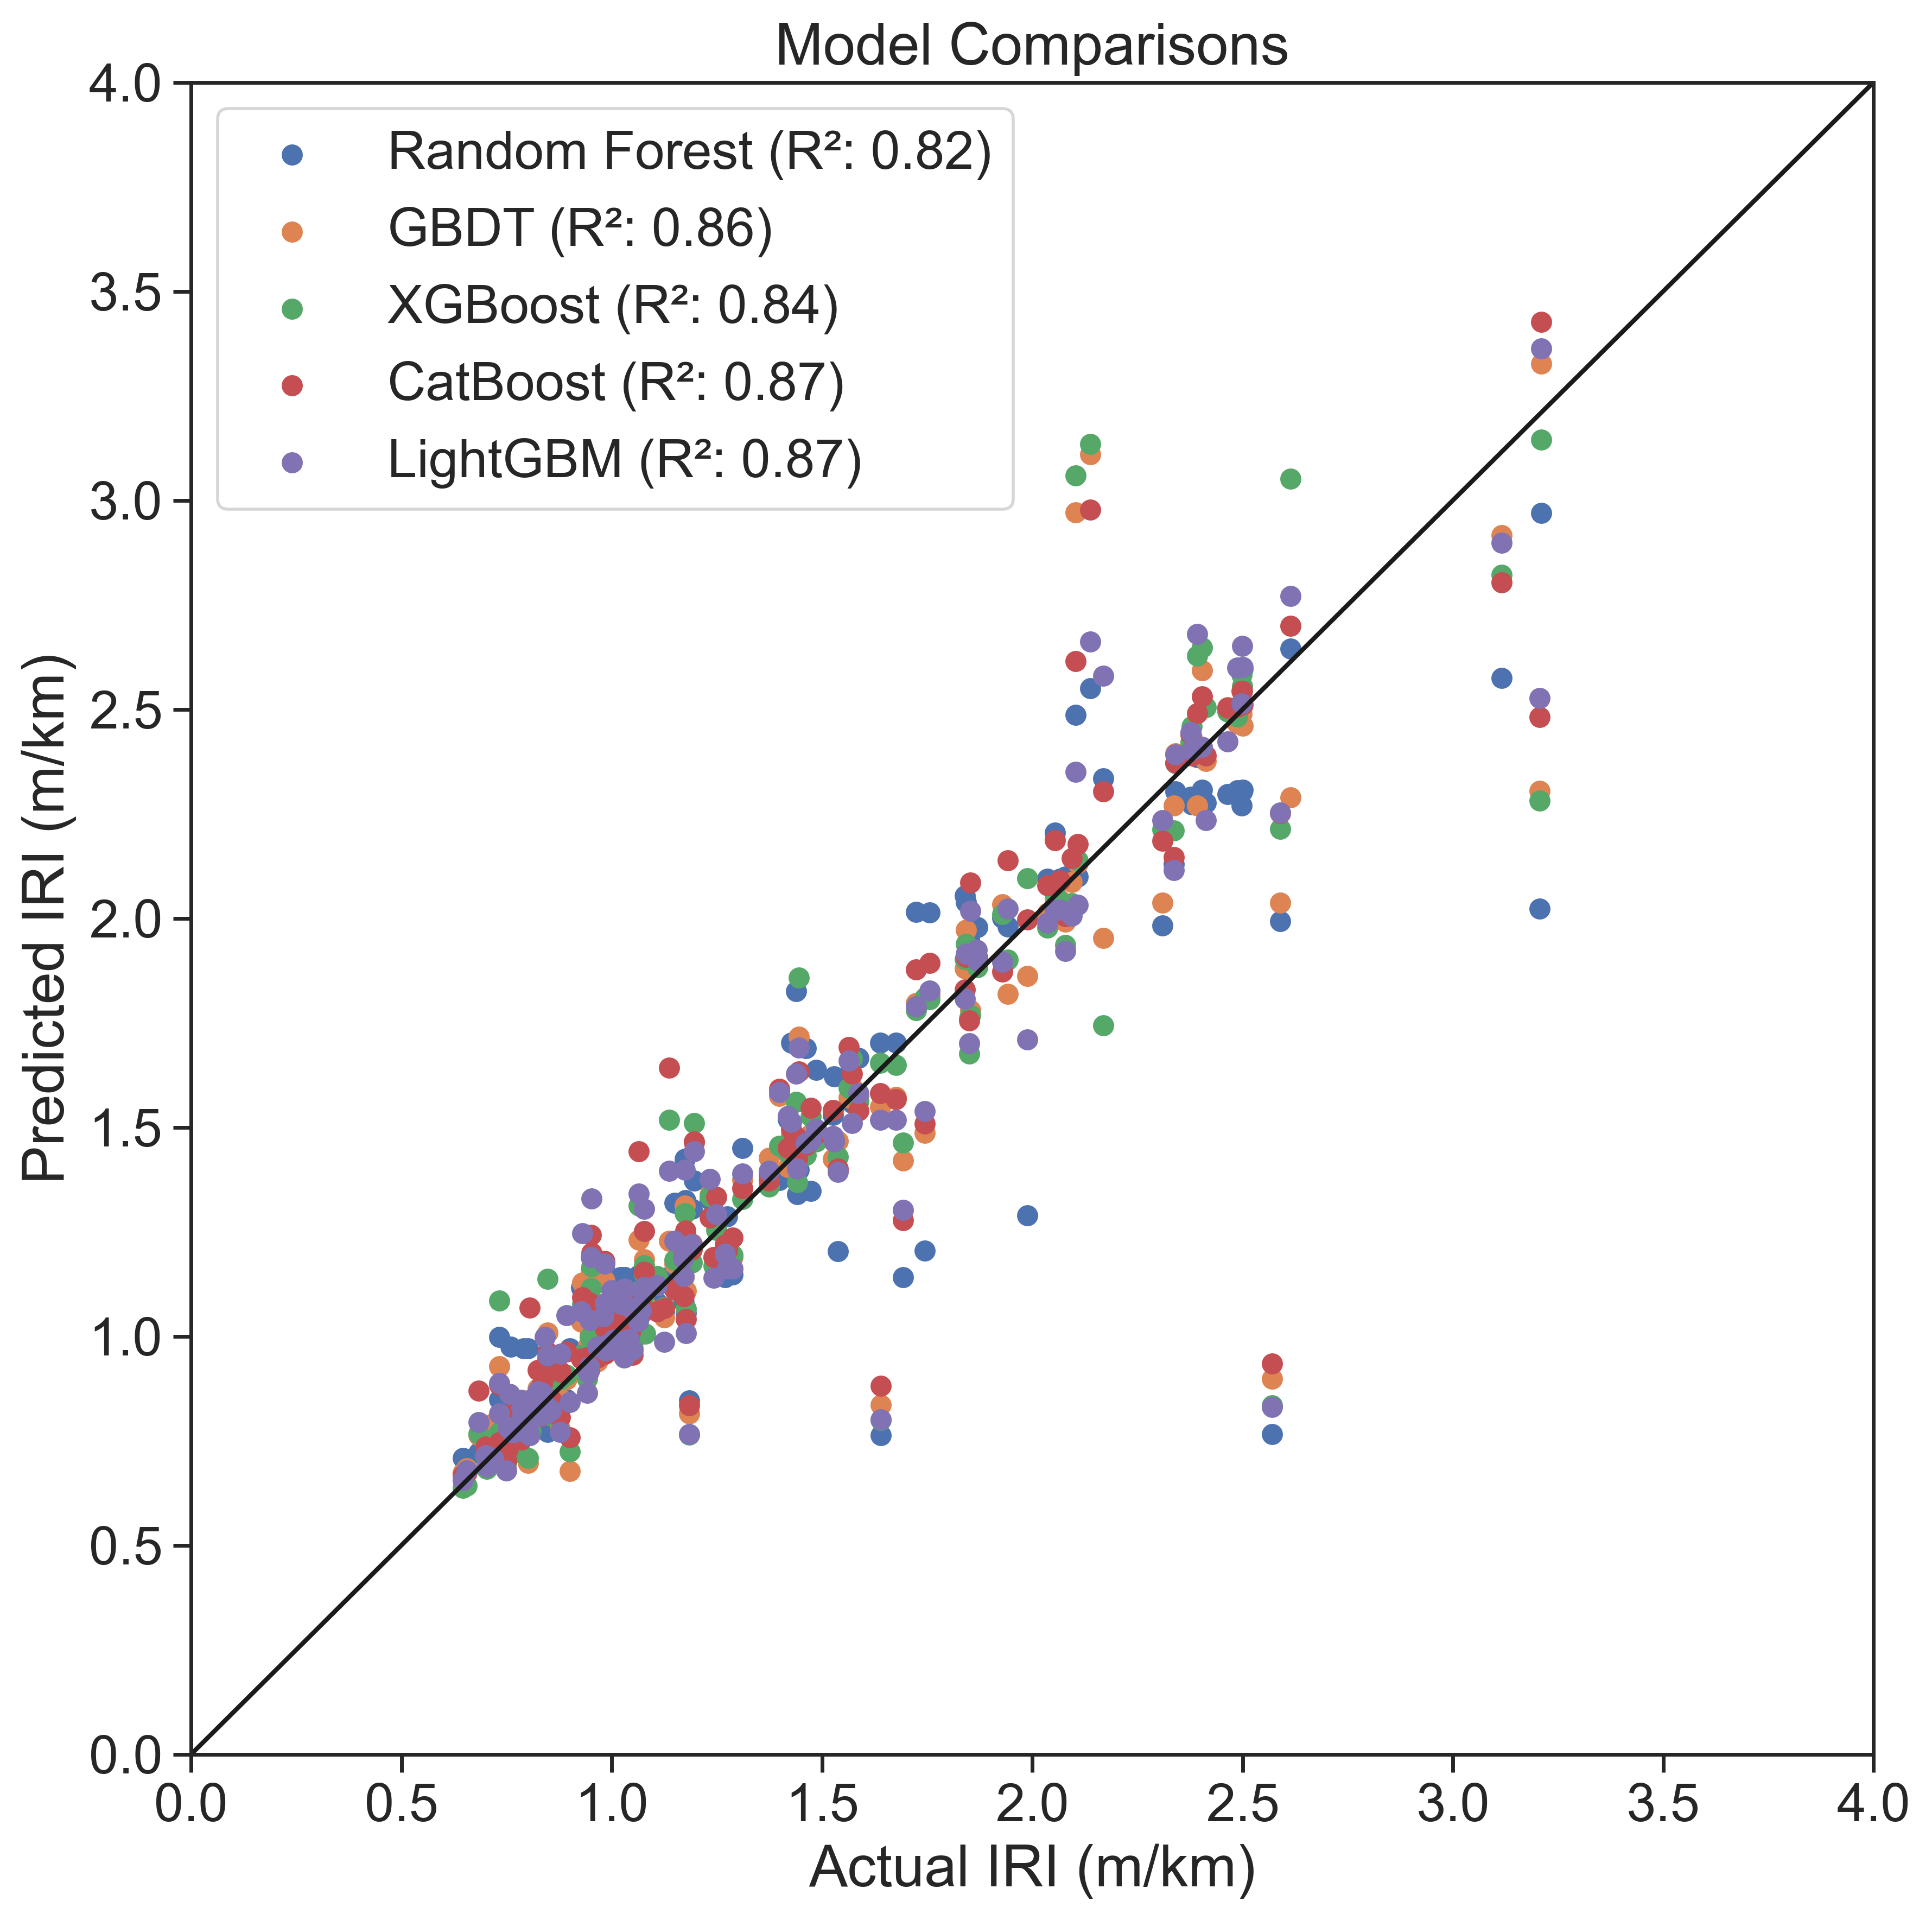

In [11]:
# Metrics calculation and visualization
metrics_data = {
    'Model': [],
    'R2': [],
    'RMSE': [],
    'MAE': []
}

plt.figure(figsize=(10, 10))
identity_line = np.linspace(0, 4, 100)
plt.plot(identity_line, identity_line, 'k-')

# plt.hlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
# plt.vlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)

for name, preds in results.items():
    metrics_data['Model'].append(name)
    metrics_data['R2'].append(round(r2_score(y_test, preds), 2))
    metrics_data['RMSE'].append(round(mean_squared_error(y_test, preds, squared=False), 2))
    metrics_data['MAE'].append(round(mean_squared_error(y_test, preds), 2))

    plt.scatter(y_test, preds, label=f"{name} (R²: {metrics_data['R2'][-1]})")

plt.axis([0, 4, 0, 4])
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predicted IRI (m/km)')
plt.legend()
plt.title("Model Comparisons")
plt.savefig('img/model_comparisons.png')
plt.show()

In [12]:
# Display metrics
df_metrics = pd.DataFrame(metrics_data)
print(df_metrics)

           Model    R2  RMSE   MAE
0  Random Forest  0.82  0.25  0.06
1           GBDT  0.86  0.22  0.05
2        XGBoost  0.84  0.24  0.06
3       CatBoost  0.87  0.21  0.04
4       LightGBM  0.87  0.21  0.05


In [13]:
# Save models
import pickle

model_paths = {
    'Random Forest': 'models/ltppIRI_RF.mlmodel',
    'GBDT': 'models/ltppIRI_GBDT.mlmodel',
    'XGBoost': 'models/ltppIRI_XGBoost.mlmodel',
    'CatBoost': 'models/ltppIRI_CatBoost.mlmodel',
    'LightGBM': 'models/ltppIRI_LightGBM.mlmodel'
}

for name, reg in regressors.items():
    with open(model_paths[name], 'wb') as f:
        pickle.dump(reg, f)


In [14]:
# View data
def query_data(df, id):  
    return df[df['STATION_ID'] == id]

unique_station_ids = df['STATION_ID'].unique()
unique_station_ids

array(['34_1638', '16_1021', '30_1001', '37_1030', '23_1012', '50_1002',
       '6_1253', '18_2009', '53_1501', '56_2018', '85_1801', '85_1808',
       '26_1010', '6_2647', '26_1001', '27_1029', '28_3082', '13_4111',
       '12_9054', '12_4108', '12_4107', '12_4105', '12_4103', '12_4099',
       '12_4097', '12_3996', '17_1003', '28_3083', '1_1021', '48_3609',
       '48_3559', '48_1060', '48_1049', '47_3075', '45_1008', '40_4165',
       '40_1015', '35_2006', '35_1112', '35_1022', '12_3995', '29_1005',
       '12_1060', '28_1016', '6_8151', '1_4126', '6_2004', '6_8201',
       '5_3048', '1_4125', '15_7080', '40_1017', '15_1008', '15_1006',
       '15_1003'], dtype=object)

In [15]:
query_data(df, '18_2009')

YEAR   SN  PRECIPITATION  TEMPERATURE     IRI  INITIAL_IRI STATION_ID  \
106  1989  7.2    1212.699951     9.900000  1.5256       1.5256    18_2009   
107  1990  7.2    1041.816671    10.966667  1.6126       1.5256    18_2009   
108  1991  7.2     895.500000    11.800000  1.6996       1.5256    18_2009   
109  1992  7.2    1192.900024    10.400000  1.7424       1.5256    18_2009   
110  1993  7.2    1041.816671    10.966667  1.8355       1.5256    18_2009   
111  1994  7.2     821.200012    10.500000  1.9286       1.5256    18_2009   
112  1995  7.2     925.799988    10.600000  2.2754       1.5256    18_2009   
113  1996  7.2    1041.816671    10.966667  2.6686       1.5256    18_2009   
114  1997  7.2    1041.816671    10.966667  3.0618       1.5256    18_2009   
115  1998  7.2    1202.800049    12.600000  3.4550       1.5256    18_2009   

      AGE        AADTT  
106   8.0   450.000000  
107   9.0   915.500000  
108  10.0  1396.500000  
109  11.0  1879.500000  
110  12.0  2357.000000  
111  13.0  2829.000000  
112  14.0  3431.000000  
113  15.0  4051.333333  
114  16.0  4690.000000  
115  17.0  5347.000000

In [16]:
query_data(df, '48_1060')

YEAR   SN  PRECIPITATION  TEMPERATURE       IRI  INITIAL_IRI STATION_ID  \
361  1990  6.5     940.299988    22.299999  1.246000        1.246    48_1060   
362  1991  6.5    1306.599976    21.900000  1.267200        1.246    48_1060   
363  1992  6.5    1074.657148    21.928571  1.304250        1.246    48_1060   
364  1993  6.5    1224.800049    21.500000  1.341300        1.246    48_1060   
365  1994  6.5    1063.300049    22.200001  1.373533        1.246    48_1060   
366  1995  6.5     886.599976    22.100000  1.429200        1.246    48_1060   
367  1996  6.5    1074.657148    21.928571  1.550225        1.246    48_1060   
368  1997  6.5    1466.500000    21.299999  1.671250        1.246    48_1060   
369  1998  6.5    1074.657148    21.928571  1.697025        1.246    48_1060   
370  1999  6.5     634.500000    22.200001  1.722800        1.246    48_1060   

      AGE   AADTT  
361   4.0   592.0  
362   5.0  1265.0  
363   6.0  1943.5  
364   7.0  2627.5  
365   8.0  3371.5  
366   9.0  4132.5  
367  10.0  5046.0  
368  11.0  6112.0  
369  12.0  7234.0  
370  13.0  8412.0

In [17]:
# Predict IRI
def predict_IRI(model_name, SN, PRECIPITATION, TEMPERATURE, INITIAL_IRI, AGE, AADTT):
    if model_name not in regressors:
        raise ValueError(f"Invalid model: {model_name}")

    input_data = {
        'SN': [SN],
        'PRECIPITATION': [PRECIPITATION],
        'TEMPERATURE': [TEMPERATURE],
        'INITIAL_IRI': [INITIAL_IRI],
        'AGE': [AGE],
        'AADTT': [AADTT]
    }

    input_df = pd.DataFrame(input_data)
    return regressors[model_name].predict(input_df)[0]



In [23]:
# Test: STATION_ID 18_2009, Year 1998. Expected IRI: 3.4550.
predicted_value = predict_IRI('CatBoost', 7.2, 1202, 12.6, 1.5256, 17, 5347)
predicted_value

3.2345057046704646

In [24]:
# Test: STATION_ID 48_1060, Year 1998. Expected IRI: 1.697025.
predicted_value = predict_IRI('CatBoost', 6.5, 1074, 21.9, 1.246, 12, 7234)
predicted_value

1.696003379225687

In [20]:
# Code to be adjusted and implemented.

# def predict_future_IRI(model_name, STATION_ID, range_years, SN=None, AADTT=None, PRECIPITATION=None, TEMPERATURE=None):
    
#     # Using global variable df to fetch station details.
#     # Assuming df is your main dataframe that has all the details.
#     station_data = df[df['STATION_ID'] == STATION_ID].iloc[-1]  # Getting the latest data for the STATION_ID
    
#     if not SN:
#         SN = station_data['SN']
    
#     if not PRECIPITATION:
#         PRECIPITATION = station_data['PRECIPITATION']
    
#     if not TEMPERATURE:
#         TEMPERATURE = station_data['TEMPERATURE']
        
#     AGE = station_data['AGE'] + range_years  # Calculating age for the future
    
#     if not AADTT:
#         # Assuming a constant growth rate for AADTT; for more complex forecasting methods you might need additional data.
#         current_AADTT = station_data['AADTT']
#         growth_rate = (current_AADTT - df[df['STATION_ID'] == STATION_ID].iloc[-2]['AADTT']) / current_AADTT
#         AADTT = current_AADTT * (1 + growth_rate) ** range_years
    
#     model = models[model_name]
    
#     # Creating an input array for prediction
#     input_data = np.array([SN, AGE, AADTT, PRECIPITATION, TEMPERATURE]).reshape(1, -1)
    
#     # Predicting the future IRI
#     future_IRI = model.predict(input_data)[0]
    
#     return future_IRI


# predicted_IRI = predict_future_IRI("XGBoost", "15_1004", 10)
# print(f"Predicted IRI for {predicted_IRI[2]} years in the future (using {predicted_IRI[0]}) for STATION_ID {predicted_IRI[1]} is: {predicted_IRI}")